In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path

import sys
sys.path.append("..")
sys.path.append("../src/")
from structures import ConventionalCNN
from dataloader import loadCAMELS, split_expanded_dataset_from_json, ExpandedInstanceDataset
sys.path.append("../test/")
from train_sb import _random_split_expanded_dataset as random_split_expanded_dataset

dtype = torch.float32
torch.set_default_dtype(dtype)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 64
individual = True

Using device: cuda


## Helper Functions

In [8]:
import gc


def clear_memory():
    """Clear GPU and CPU memory."""
    gc.collect()
    torch.cuda.empty_cache()


def log_normalize(arr, individual=False, ref_stats=None):
    """Match dataloader normalization.

    - individual=True: divide each map by its sum (use ref_stats as sums if provided), log10, then global z-score; returns (mean, std, sums).

    - individual=False: log10 then z-score; ref_stats supplies (mean, std) if given.

    """
    arr = np.asarray(arr)
    if individual:
        sums = ref_stats if ref_stats is not None else arr.sum(axis=(1, 2), keepdims=True)
        arr = arr / sums
        arr = np.log10(arr)
        mean_val, std_val = arr.mean(), arr.std()
        return (arr - mean_val) / std_val, (mean_val, std_val, sums)
    arr = np.log10(arr)
    if ref_stats is not None:
        mean_val, std_val = ref_stats
    else:
        mean_val, std_val = arr.mean(), arr.std()
    return (arr - mean_val) / std_val, (mean_val, std_val)


def _apply_sb35_windowing(data: np.ndarray, step: int = 10, length: int = 5) -> np.ndarray:
    """Match SB35_half/cutout sampling: take 5 frames every 10."""
    arr = np.arange(data.shape[0])
    starts = np.arange(0, len(arr) - length + 1, step)
    idx = (starts[:, None] + np.arange(length)[None, :]).reshape(-1)
    return data[idx]


def _apply_crop(data: np.ndarray, crop: str = "tl") -> np.ndarray:
    h, w = data.shape[1], data.shape[2]
    hh, ww = h // 2, w // 2
    if crop == "tl":
        return data[:, :hh, :ww]
    if crop == "tr":
        return data[:, :hh, ww:]
    if crop == "bl":
        return data[:, hh:, :ww]
    if crop == "br":
        return data[:, hh:, ww:]
    raise ValueError(f"Unknown crop: {crop}")


def make_random_test_loader(data_norm, labels, chunk_size, seed, val_ratio=0.1, test_ratio=0.1, shuffle_loader=False):
    tensor = torch.tensor(data_norm, dtype=dtype)
    labels_t = torch.tensor(labels, dtype=dtype) if not isinstance(labels, torch.Tensor) else labels
    _, _, test_set = random_split_expanded_dataset(tensor, labels_t, chunk_size=chunk_size, val_ratio=val_ratio, test_ratio=test_ratio, seed=seed)
    return DataLoader(test_set, batch_size=batch_size, shuffle=shuffle_loader)


def load_model_single(path, input_shape=(256, 256)):
    model = ConventionalCNN(input_shape=input_shape, output_shape=1, H=16, output_positive=True).to(device)
    state = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(state)
    return model


def load_model_pair(om_path, sig_path, input_shape=(256, 256)):
    return load_model_single(om_path, input_shape=input_shape), load_model_single(sig_path, input_shape=input_shape)


def get_predictions(model_om, model_sig, val_loader, minmax):
    model_om.eval()
    model_sig.eval()
    preds_om, preds_sig, truths = [], [], []


    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            preds_om.append(model_om(inputs).cpu())
            preds_sig.append(model_sig(inputs).cpu())
            truths.append(targets.cpu())
            del inputs


    preds = np.c_[torch.cat(preds_om).numpy(), torch.cat(preds_sig).numpy()]
    truths = torch.cat(truths).numpy()
    del preds_om, preds_sig
    clear_memory()


    preds = preds * (minmax[:2, 1] - minmax[:2, 0]) + minmax[:2, 0]
    mse = ((preds - truths) ** 2).mean(axis=0)
    print(f"  MSE: Om={mse[0]:.4e}, Sig8={mse[1]:.4e}")
    return truths, preds, 2


def _metrics_point(y_true, y_pred, y_sigma=None, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    resid = y_pred - y_true
    ss_res = np.sum(resid ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + eps
    r2 = 1.0 - ss_res / ss_tot
    rmse = np.sqrt(np.mean(resid ** 2))
    denom = np.maximum(np.abs(y_true), eps)
    eps_rel = np.mean(np.abs(resid) / denom)
    if y_sigma is None:
        chi2_red = np.nan
    else:
        y_sigma = np.maximum(np.asarray(y_sigma), eps)
        chi2 = np.sum((resid / y_sigma) ** 2)
        dof = max(int(y_true.size) - 1, 1)
        chi2_red = chi2 / dof
    return r2, eps_rel, rmse, chi2_red


def _metrics_with_uncertainty(y_true, y_pred, y_sigma=None, n_boot=200, seed=0):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_sigma is not None:
        y_sigma = np.asarray(y_sigma)
    n = y_true.shape[0]
    if n <= 1:
        r2, eps_rel, rmse, chi2_red = _metrics_point(y_true, y_pred, y_sigma=y_sigma)
        return (r2, 0.0), (eps_rel, 0.0), (rmse, 0.0), (chi2_red, 0.0)
    rng = np.random.default_rng(seed)
    samples = np.empty((n_boot, 4), dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_pred[idx]
        ys = y_sigma[idx] if y_sigma is not None else None
        samples[b] = _metrics_point(yt, yp, y_sigma=ys)
    means = samples.mean(axis=0)
    stds = samples.std(axis=0, ddof=1)
    return (means[0], stds[0]), (means[1], stds[1]), (means[2], stds[2]), (means[3], stds[3])


def plot_comparison(data, chunk_size, title, num_samples=200, n_boot=200, seed=0):
    truths, preds, _ = data
    target_names = [r"$\Omega_m$", r"$\sigma_8$"]
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    chunks = preds.reshape(-1, chunk_size, 2)
    pred_mean = chunks.mean(axis=1)
    pred_std = chunks.std(axis=1)
    true = truths[::chunk_size]
    n = min(num_samples, true.shape[0])
    for i, ax in enumerate(axs):
        x = true[:n, i]
        y = pred_mean[:n, i]
        yerr = pred_std[:n, i]
        (r2_m, r2_s), (eps_m, eps_s), (rmse_m, rmse_s), (chi2_m, chi2_s) = _metrics_with_uncertainty(x, y, y_sigma=yerr, n_boot=n_boot, seed=seed + i)
        eps_pct_m = 100.0 * eps_m
        eps_pct_s = 100.0 * eps_s
        lines = [
            rf"$R^2 = {r2_m:.4f} \pm {r2_s:.4f}$",
            rf"$\epsilon = ({eps_pct_m:.2f} \pm {eps_pct_s:.2f})\%$",
            rf"$\mathrm{{RMSE}} = {rmse_m:.3e} \pm {rmse_s:.3e}$",
            rf"$\chi^2_\nu = {chi2_m:.3e} \pm {chi2_s:.3e}$",
        ]
        textstr = "\n".join(lines)
        ax.errorbar(x, y, yerr=yerr, fmt='none', capsize=2, ecolor='tab:orange', alpha=0.7)
        ax.scatter(x, y, s=4, c='k', zorder=10)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='Ideal')
        ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=9, va='bottom', ha='right', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
        ax.set_xlabel("Truth")
        ax.set_ylabel("Prediction")
        ax.set_title(target_names[i])
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    fig.suptitle(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig


def compute_stats(data):
    truths, preds, _ = data
    return {
        'bias_om': np.mean(truths[:, 0] - preds[:, 0]),
        'scatter_om': np.std(truths[:, 0] - preds[:, 0]),
        'bias_sig': np.mean(truths[:, 1] - preds[:, 1]),
        'scatter_sig': np.std(truths[:, 1] - preds[:, 1]),
    }


def compute_scorebox_scores(data, chunk_size, n_boot=200, seed=0):
    truths, preds, _ = data
    chunks = preds.reshape(-1, chunk_size, 2)
    pred_mean = chunks.mean(axis=1)
    pred_std = chunks.std(axis=1)
    true = truths[::chunk_size]
    out = {}
    for i, tag in enumerate(['om', 'sig']):
        x = true[:, i]
        y = pred_mean[:, i]
        yerr = pred_std[:, i]
        (r2_m, r2_s), (eps_m, eps_s), (rmse_m, rmse_s), (chi2_m, chi2_s) = _metrics_with_uncertainty(x, y, y_sigma=yerr, n_boot=n_boot, seed=seed + i)
        out[f'r2_{tag}_m'] = float(r2_m)
        out[f'r2_{tag}_s'] = float(r2_s)
        out[f'eps_{tag}_pct_m'] = float(100.0 * eps_m)
        out[f'eps_{tag}_pct_s'] = float(100.0 * eps_s)
        out[f'rmse_{tag}_m'] = float(rmse_m)
        out[f'rmse_{tag}_s'] = float(rmse_s)
        out[f'chi2_{tag}_m'] = float(chi2_m)
        out[f'chi2_{tag}_s'] = float(chi2_s)
    return out


def _ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def _slugify(name: str) -> str:
    return name.replace(":", "").replace(" ", "_").replace("|", "-").replace(">", "to").replace("/", "-")


def run_evaluation(model_om, model_sig, val_loader, minmax, chunk_size, title, num_samples=200, save_dir=None, base_name=None):
    print(f"\n{title}")
    data = get_predictions(model_om, model_sig, val_loader, minmax)
    fig = plot_comparison(data, chunk_size, title, num_samples=num_samples)
    if save_dir is not None:
        _ensure_dir(Path(save_dir))
        stem = _slugify(base_name or title)
        fig.savefig(Path(save_dir) / f"{stem}.png", dpi=200, bbox_inches="tight")
        fig.savefig(Path(save_dir) / f"{stem}.pdf", bbox_inches="tight")
    plt.show()
    stats = compute_stats(data)
    stats.update(compute_scorebox_scores(data, chunk_size=chunk_size, n_boot=200, seed=0))
    del data, fig
    clear_memory()
    return stats

## Config

In [3]:
model_dir = Path("../data/models")
chunk_sb28 = 15
chunk_sb35_cutout = 15
val_ratio = 0.1
test_ratio = 0.1
seeds = [0, 42, 123, 456, 789]

results_dir = Path("../plot/random_cross_eval_no_monopole")
plots_dir = results_dir / "figures"
tables_dir = results_dir / "tables"
_ensure_dir(plots_dir)
_ensure_dir(tables_dir)

all_results = []

## Load Data and Stats

In [9]:
# SB28
_dataSB28, _labelsSB28, minmaxSB28 = loadCAMELS(field="Mtot", box="SB28", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:, :2], dtype=dtype)
dataSB28_norm, statsSB28 = log_normalize(_dataSB28, individual=individual)
sumsSB28 = statsSB28[2] if individual else None


# SB35 cutout (normalize once, then window + crop)
_dataSB35, _labelsSB35, minmaxSB35 = loadCAMELS(field="Mtot", box="SB35", normalization=False, individual=individual)
labelsSB35 = torch.tensor(_labelsSB35[:, :2], dtype=dtype)
dataSB35_norm, statsSB35 = log_normalize(_dataSB35, individual=individual)
sumsSB35 = statsSB35[2] if individual else None
dataSB35_window_norm = _apply_sb35_windowing(dataSB35_norm)
dataSB35_cutout_norm = _apply_crop(dataSB35_window_norm, crop="tl")
statsSB35_cutout = statsSB35


del dataSB35_window_norm
clear_memory()

## Self Validation (random splits by seed)


SB28 self (seed=0)
  MSE: Om=2.3532e-03, Sig8=6.9763e-03


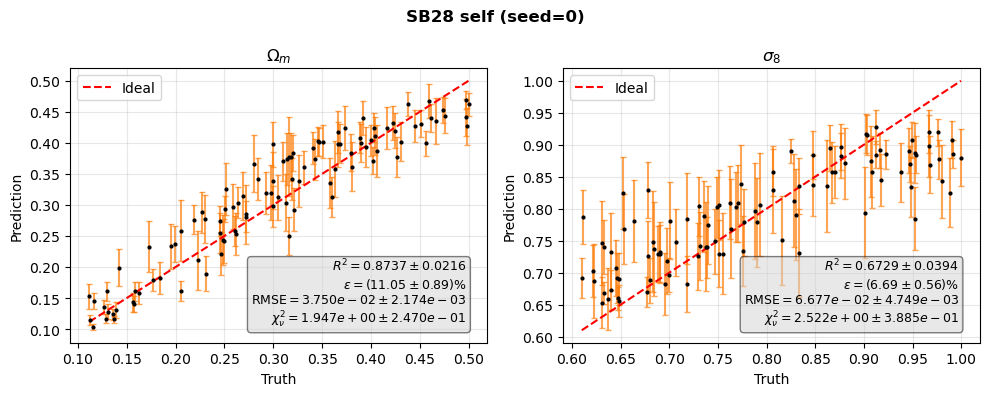


SB35_cutout self (seed=0)
  MSE: Om=3.4345e-03, Sig8=6.1251e-03


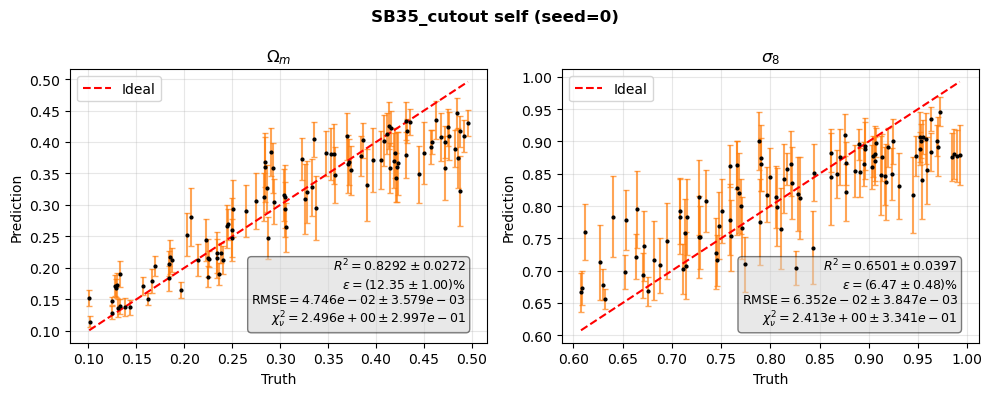


SB28 self (seed=42)
  MSE: Om=2.5069e-03, Sig8=5.9457e-03


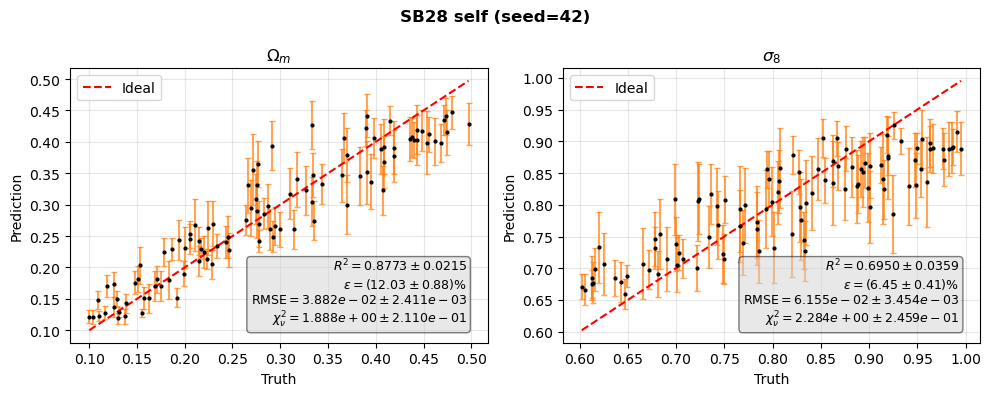


SB35_cutout self (seed=42)
  MSE: Om=2.2675e-03, Sig8=7.1549e-03


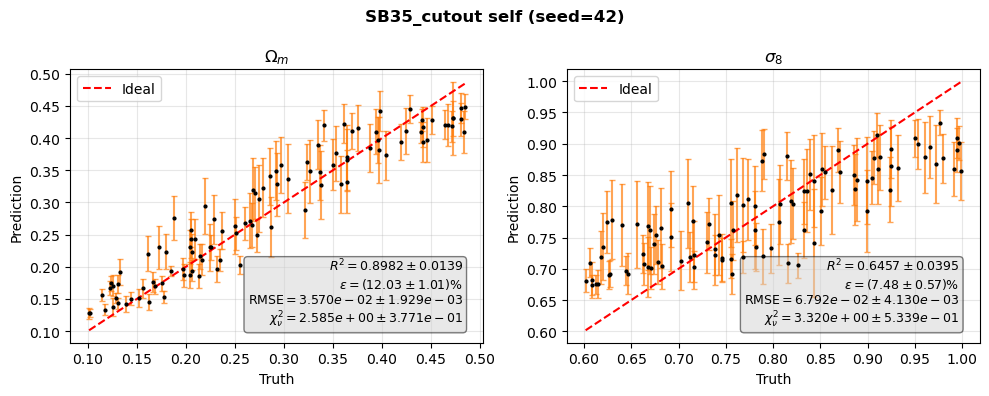


SB28 self (seed=123)
  MSE: Om=2.4740e-03, Sig8=7.6069e-03


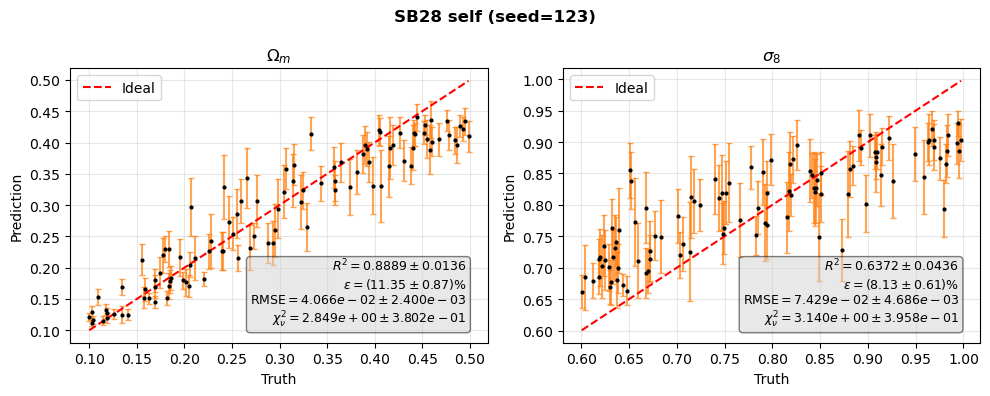


SB35_cutout self (seed=123)
  MSE: Om=2.7197e-03, Sig8=7.2692e-03


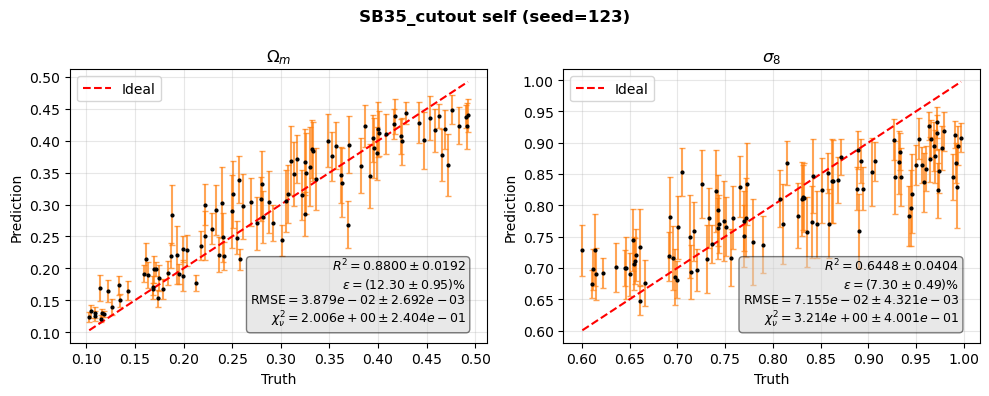


SB28 self (seed=456)
  MSE: Om=2.4598e-03, Sig8=8.0594e-03


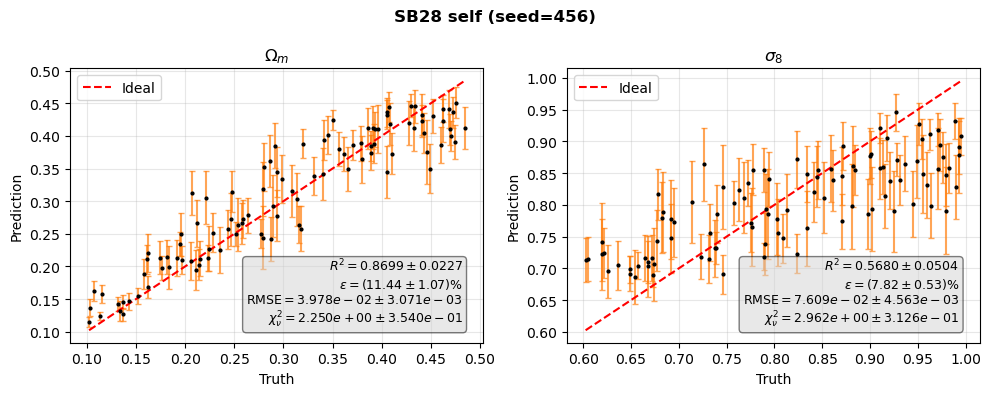


SB35_cutout self (seed=456)
  MSE: Om=2.6857e-03, Sig8=6.0497e-03


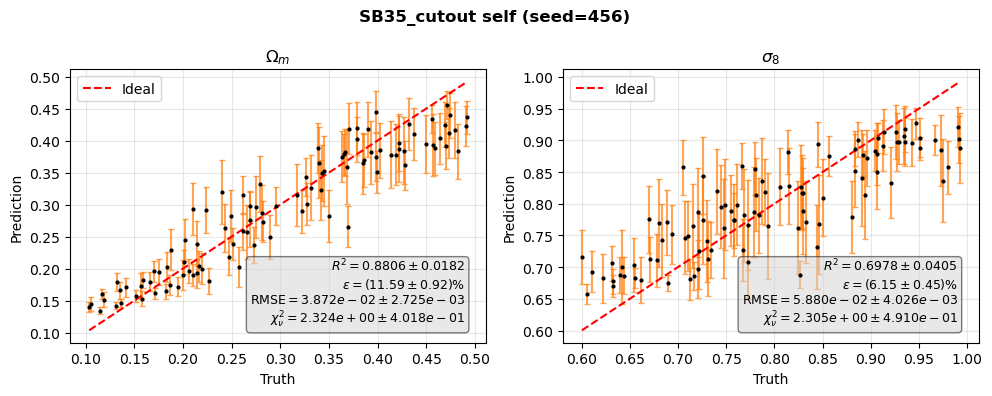


SB28 self (seed=789)
  MSE: Om=3.2690e-03, Sig8=5.5722e-03


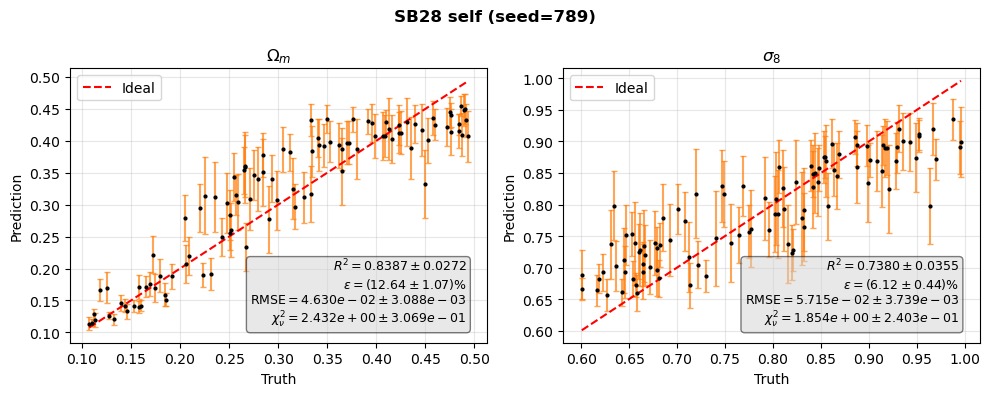


SB35_cutout self (seed=789)
  MSE: Om=2.6754e-03, Sig8=5.9042e-03


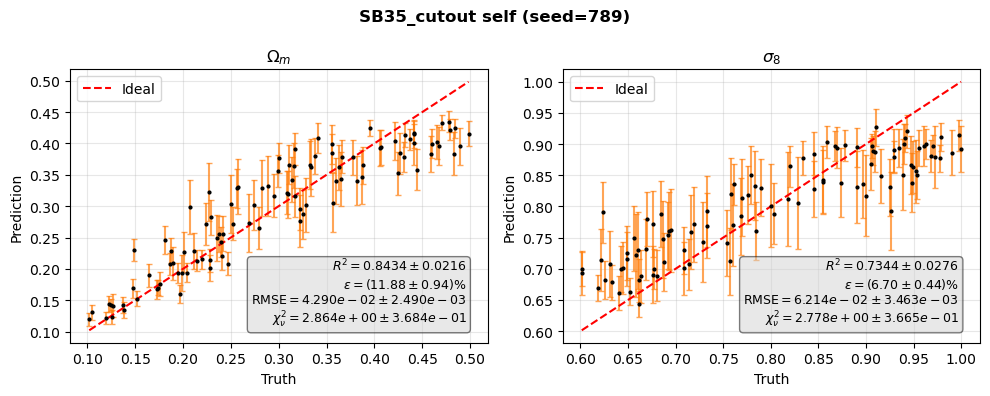

In [10]:
self_results = []

for seed in seeds:
    # SB28 self
    loader_sb28 = make_random_test_loader(dataSB28_norm, labelsSB28, chunk_size=chunk_sb28, seed=seed, val_ratio=val_ratio, test_ratio=test_ratio)
    model_om, model_sig = load_model_pair(model_dir / f"SB28_om_no_monopole_seed{seed}_best.pt", model_dir / f"SB28_sig_no_monopole_seed{seed}_best.pt", input_shape=(256, 256))
    res = run_evaluation(model_om, model_sig, loader_sb28, minmaxSB28, chunk_sb28, f"SB28 self (seed={seed})", save_dir=plots_dir, base_name=f"sb28_seed{seed}_self_no_monopole")
    self_results.append((f"SB28 self seed {seed}", res))
    del loader_sb28, model_om, model_sig
    clear_memory()

    # SB35_cutout self
    loader_sb35 = make_random_test_loader(dataSB35_cutout_norm, labelsSB35, chunk_size=chunk_sb35_cutout, seed=seed, val_ratio=val_ratio, test_ratio=test_ratio)
    model_om, model_sig = load_model_pair(model_dir / f"SB35_cutout15_om_no_monopole_seed{seed}_best.pt", model_dir / f"SB35_cutout15_sig_no_monopole_seed{seed}_best.pt", input_shape=(256, 256))
    res = run_evaluation(model_om, model_sig, loader_sb35, minmaxSB35, chunk_sb35_cutout, f"SB35_cutout self (seed={seed})", save_dir=plots_dir, base_name=f"sb35cutout_seed{seed}_self_no_monopole")
    self_results.append((f"SB35_cutout self seed {seed}", res))
    del loader_sb35, model_om, model_sig
    clear_memory()

## Cross Validation SB28 ↔ SB35_cutout (matching seeds)


SB28 model on SB35_cutout (seed=0)


  MSE: Om=3.2326e-03, Sig8=7.0688e-03


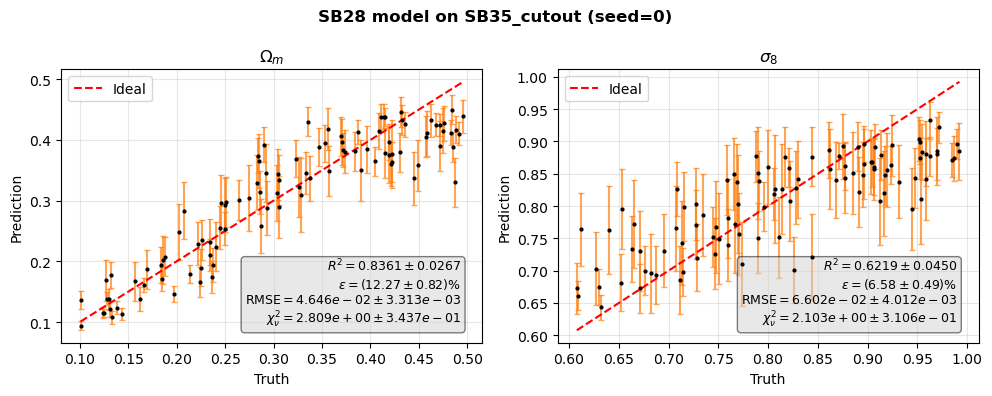


SB35_cutout model on SB28 (seed=0)
  MSE: Om=2.5362e-03, Sig8=6.8242e-03


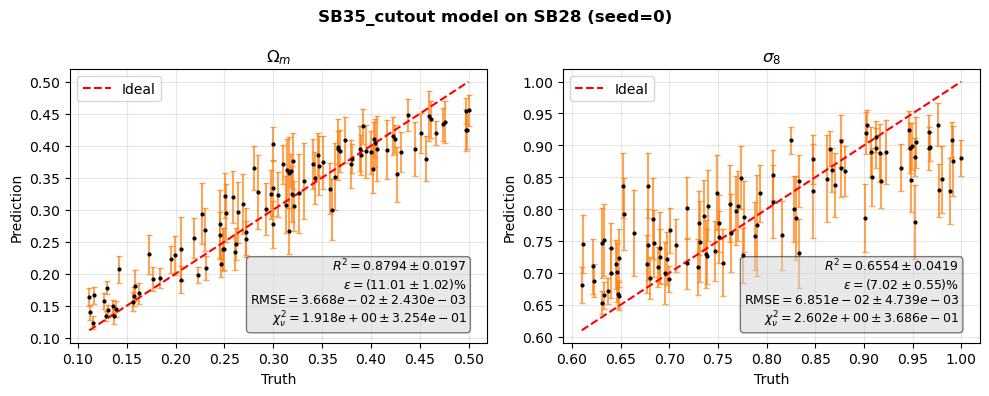


SB28 model on SB35_cutout (seed=42)
  MSE: Om=2.7485e-03, Sig8=7.1626e-03


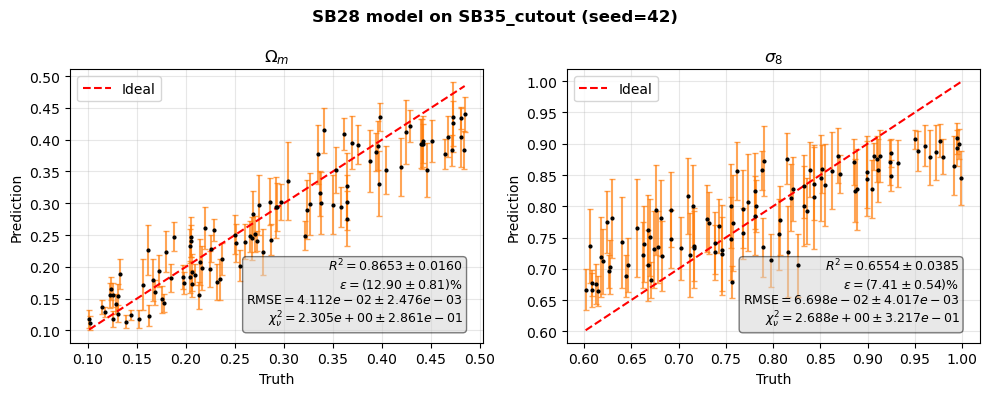


SB35_cutout model on SB28 (seed=42)
  MSE: Om=2.8436e-03, Sig8=7.0194e-03


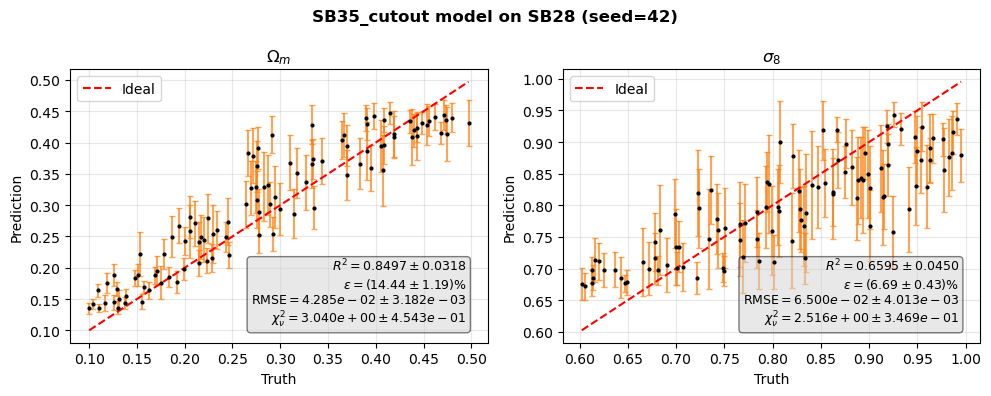


SB28 model on SB35_cutout (seed=123)
  MSE: Om=2.8857e-03, Sig8=7.8594e-03


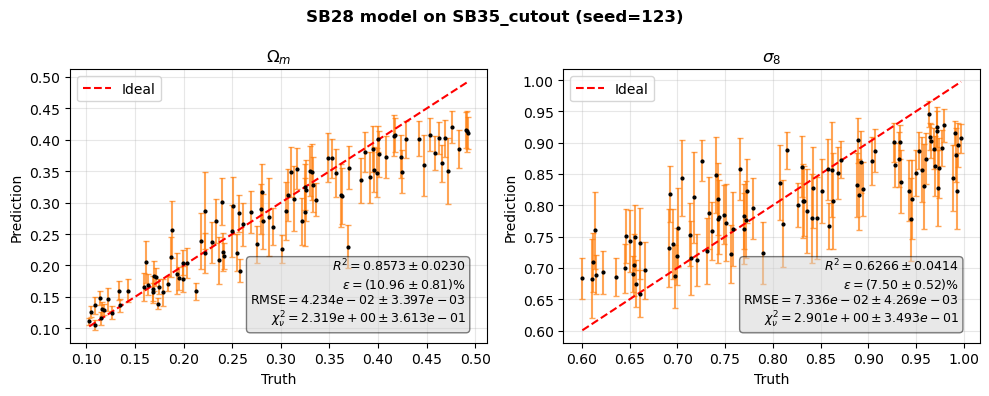


SB35_cutout model on SB28 (seed=123)
  MSE: Om=2.5691e-03, Sig8=7.3193e-03


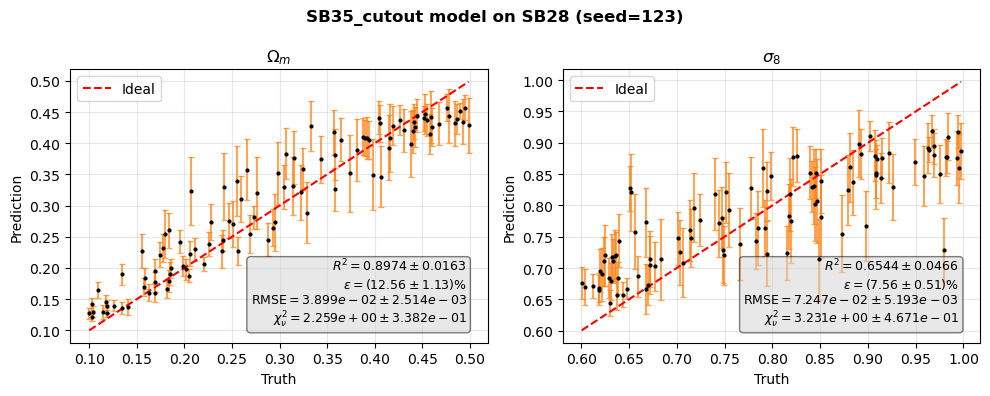


SB28 model on SB35_cutout (seed=456)
  MSE: Om=2.7644e-03, Sig8=6.7395e-03


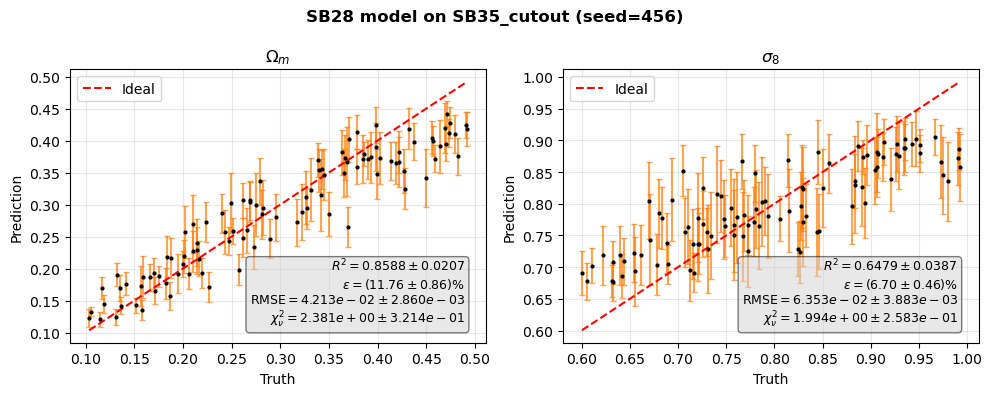


SB35_cutout model on SB28 (seed=456)
  MSE: Om=2.8477e-03, Sig8=8.7519e-03


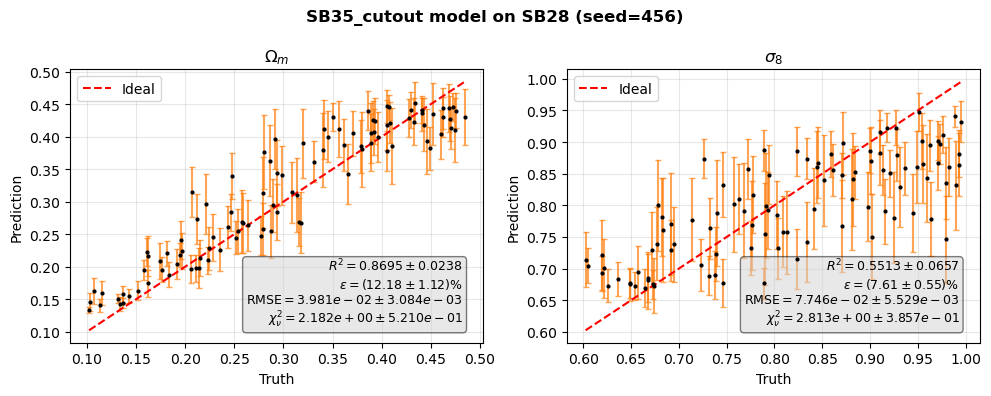


SB28 model on SB35_cutout (seed=789)
  MSE: Om=3.1235e-03, Sig8=6.2003e-03


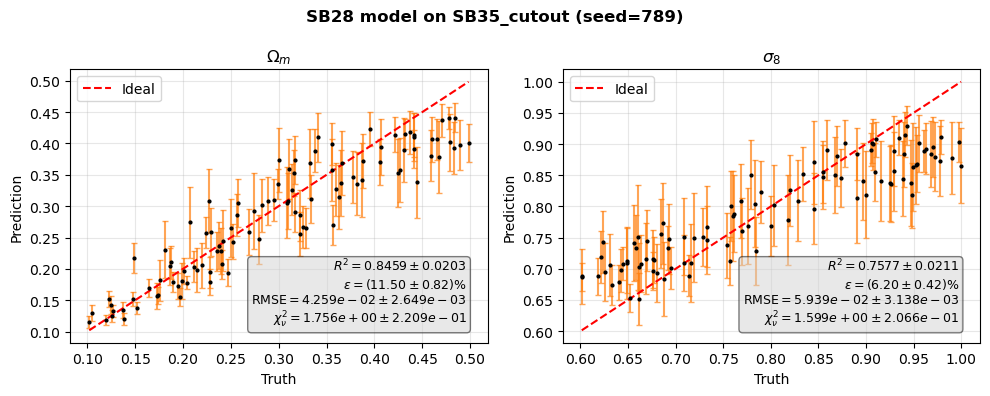


SB35_cutout model on SB28 (seed=789)
  MSE: Om=3.4136e-03, Sig8=5.9989e-03


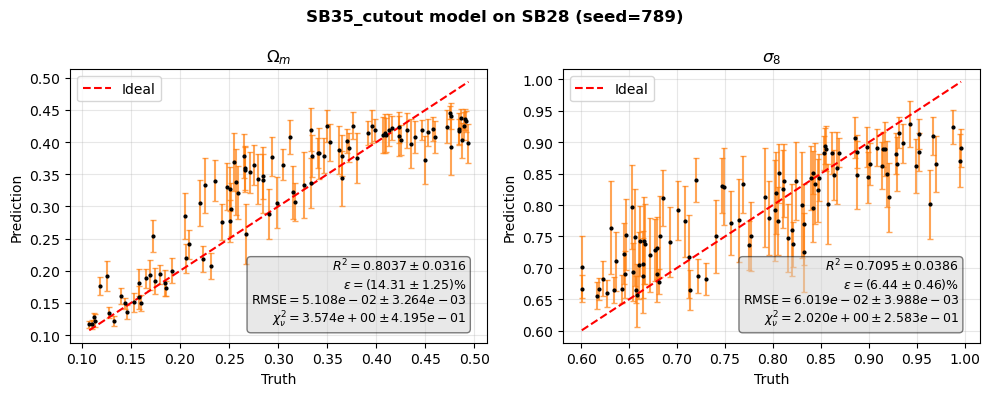

In [11]:
cross_results = []


for seed in seeds:
    # SB35_cutout data already normalized (per-sum); reuse for SB28 model
    loader_sb35_for_sb28 = make_random_test_loader(dataSB35_cutout_norm, labelsSB35, chunk_size=chunk_sb35_cutout, seed=seed, val_ratio=val_ratio, test_ratio=test_ratio)
    model_om, model_sig = load_model_pair(model_dir / f"SB28_om_no_monopole_seed{seed}_best.pt", model_dir / f"SB28_sig_no_monopole_seed{seed}_best.pt", input_shape=(256, 256))
    res = run_evaluation(model_om, model_sig, loader_sb35_for_sb28, minmaxSB28, chunk_sb35_cutout, f"SB28 model on SB35_cutout (seed={seed})", save_dir=plots_dir, base_name=f"sb28_seed{seed}_to_sb35cutout_no_monopole")
    cross_results.append((f"SB28 → SB35_cutout seed {seed}", res))
    del loader_sb35_for_sb28, model_om, model_sig
    clear_memory()


    # SB28 data already normalized per-sum; reuse for SB35 model
    loader_sb28_for_sb35 = make_random_test_loader(dataSB28_norm, labelsSB28, chunk_size=chunk_sb28, seed=seed, val_ratio=val_ratio, test_ratio=test_ratio)
    model_om, model_sig = load_model_pair(model_dir / f"SB35_cutout15_om_no_monopole_seed{seed}_best.pt", model_dir / f"SB35_cutout15_sig_no_monopole_seed{seed}_best.pt", input_shape=(256, 256))
    res = run_evaluation(model_om, model_sig, loader_sb28_for_sb35, minmaxSB35, chunk_sb28, f"SB35_cutout model on SB28 (seed={seed})", save_dir=plots_dir, base_name=f"sb35cutout_seed{seed}_to_sb28_no_monopole")
    cross_results.append((f"SB35_cutout → SB28 seed {seed}", res))
    del loader_sb28_for_sb35, model_om, model_sig
    clear_memory()

## Save Summary Tables

In [12]:
def _pm(m, s, fmt):
    if m is None or s is None:
        return 'nan'
    if not np.isfinite(m) or not np.isfinite(s):
        return 'nan'
    return (fmt.format(m) + ' ± ' + fmt.format(s))

def _write_table(results, prefix):
    lines = []
    lines.append('=' * 110)
    lines.append(f'{prefix} SUMMARY')
    lines.append('=' * 110)
    header = f"{'Experiment':<40} {'Target':<6} {'R^2':>18} {'epsilon[%]':>18} {'RMSE':>18} {'chi2_nu':>18}"
    lines.append(header)
    lines.append('-' * 110)
    print('\n' + lines[0])
    print(lines[1])
    print(lines[0])
    print(header)
    print('-' * 110)
    for name, stats in results:
        for tag, label in [('om', 'Om'), ('sig', 'Sig8')]:
            r2 = _pm(stats.get(f'r2_{tag}_m'), stats.get(f'r2_{tag}_s'), '{:.4f}')
            eps = _pm(stats.get(f'eps_{tag}_pct_m'), stats.get(f'eps_{tag}_pct_s'), '{:.2f}') + '%'
            rmse = _pm(stats.get(f'rmse_{tag}_m'), stats.get(f'rmse_{tag}_s'), '{:.3e}')
            chi2 = _pm(stats.get(f'chi2_{tag}_m'), stats.get(f'chi2_{tag}_s'), '{:.3e}')
            row = f"{name:<40} {label:<6} {r2:>18} {eps:>18} {rmse:>18} {chi2:>18}"
            print(row)
            lines.append(row)
        print('-' * 110)
        lines.append('-' * 110)
    with open(tables_dir / f"{prefix.lower()}_summary.txt", 'w') as f:
        f.write('\n'.join(lines))
    tsv = ['Experiment\tTarget\tR2\tR2_std\tepsilon_pct\tepsilon_pct_std\tRMSE\tRMSE_std\tchi2_nu\tchi2_nu_std']
    for name, stats in results:
        for tag, label in [('om', 'Om'), ('sig', 'Sig8')]:
            r2m, r2s = stats.get(f'r2_{tag}_m'), stats.get(f'r2_{tag}_s')
            epsm, epss = stats.get(f'eps_{tag}_pct_m'), stats.get(f'eps_{tag}_pct_s')
            rmsem, rmses = stats.get(f'rmse_{tag}_m'), stats.get(f'rmse_{tag}_s')
            chi2m, chi2s = stats.get(f'chi2_{tag}_m'), stats.get(f'chi2_{tag}_s')
            tsv.append(f"{name}\t{label}\t{r2m}\t{r2s}\t{epsm}\t{epss}\t{rmsem}\t{rmses}\t{chi2m}\t{chi2s}")
    with open(tables_dir / f"{prefix.lower()}_summary.tsv", 'w') as f:
        f.write('\n'.join(tsv))

_write_table(self_results, 'SELF')
_write_table(cross_results, 'CROSS')


SELF SUMMARY
Experiment                               Target                R^2         epsilon[%]               RMSE            chi2_nu
--------------------------------------------------------------------------------------------------------------
SB28 self seed 0                         Om        0.8737 ± 0.0216      11.05 ± 0.89% 3.750e-02 ± 2.174e-03 1.947e+00 ± 2.470e-01
SB28 self seed 0                         Sig8      0.6729 ± 0.0394       6.69 ± 0.56% 6.677e-02 ± 4.749e-03 2.522e+00 ± 3.885e-01
--------------------------------------------------------------------------------------------------------------
SB35_cutout self seed 0                  Om        0.8292 ± 0.0272      12.35 ± 1.00% 4.746e-02 ± 3.579e-03 2.496e+00 ± 2.997e-01
SB35_cutout self seed 0                  Sig8      0.6501 ± 0.0397       6.47 ± 0.48% 6.352e-02 ± 3.847e-03 2.413e+00 ± 3.341e-01
--------------------------------------------------------------------------------------------------------------
SB28 self

In [13]:
import numpy as np

def _mean_std(vals):
    arr = np.asarray([v for v in vals if v is not None and np.isfinite(v)], dtype=float)
    if arr.size == 0:
        return np.nan, np.nan
    if arr.size == 1:
        return float(arr[0]), 0.0
    return float(arr.mean()), float(arr.std(ddof=1))


def _aggregate_results(results):
    grouped = {}
    for name, stats in results:
        base = name.split(" seed")[0].strip()
        grouped.setdefault(base, []).append(stats)

    aggregated = []
    for base, items in grouped.items():
        agg = {"count": len(items)}
        for tag in ["om", "sig"]:
            r2m, r2s = _mean_std([s.get(f"r2_{tag}_m") for s in items])
            epsm, epss = _mean_std([s.get(f"eps_{tag}_pct_m") for s in items])
            rmsem, rmses = _mean_std([s.get(f"rmse_{tag}_m") for s in items])
            chi2m, chi2s = _mean_std([s.get(f"chi2_{tag}_m") for s in items])
            agg[f"r2_{tag}_mean"] = r2m
            agg[f"r2_{tag}_std"] = r2s
            agg[f"eps_{tag}_mean"] = epsm
            agg[f"eps_{tag}_std"] = epss
            agg[f"rmse_{tag}_mean"] = rmsem
            agg[f"rmse_{tag}_std"] = rmses
            agg[f"chi2_{tag}_mean"] = chi2m
            agg[f"chi2_{tag}_std"] = chi2s
        aggregated.append((base, agg))
    return aggregated


def _write_aggregate_table(results, prefix):
    lines = []
    lines.append("=" * 120)
    lines.append(f"{prefix} SUMMARY (mean±std over seeds)")
    lines.append("=" * 120)
    header = f"{'Experiment':<40} {'Target':<6} {'R^2':>18} {'epsilon[%]':>18} {'RMSE':>18} {'chi2_nu':>18} {'N':>6}"
    lines.append(header)
    lines.append("-" * 120)
    print("\n" + lines[0])
    print(lines[1])
    print(lines[0])
    print(header)
    print("-" * 120)

    for name, stats in results:
        n = stats.get("count", 0)
        for tag, label in [("om", "Om"), ("sig", "Sig8")]:
            r2 = _pm(stats.get(f"r2_{tag}_mean"), stats.get(f"r2_{tag}_std"), "{:.4f}")
            eps = _pm(stats.get(f"eps_{tag}_mean"), stats.get(f"eps_{tag}_std"), "{:.2f}") + "%"
            rmse = _pm(stats.get(f"rmse_{tag}_mean"), stats.get(f"rmse_{tag}_std"), "{:.3e}")
            chi2 = _pm(stats.get(f"chi2_{tag}_mean"), stats.get(f"chi2_{tag}_std"), "{:.3e}")
            row = f"{name:<40} {label:<6} {r2:>18} {eps:>18} {rmse:>18} {chi2:>18} {n:>6}"
            print(row)
            lines.append(row)
        print("-" * 120)
        lines.append("-" * 120)

    with open(tables_dir / f"{prefix.lower()}_summary_over_seeds.txt", "w") as f:
        f.write("\n".join(lines))

    tsv = ["Experiment\tTarget\tR2_mean\tR2_std\tepsilon_pct_mean\tepsilon_pct_std\tRMSE_mean\tRMSE_std\tchi2_nu_mean\tchi2_nu_std\tN"]
    for name, stats in results:
        n = stats.get("count", 0)
        for tag, label in [("om", "Om"), ("sig", "Sig8")]:
            tsv.append(
                f"{name}\t{label}\t{stats.get(f'r2_{tag}_mean')}\t{stats.get(f'r2_{tag}_std')}\t{stats.get(f'eps_{tag}_mean')}\t{stats.get(f'eps_{tag}_std')}\t{stats.get(f'rmse_{tag}_mean')}\t{stats.get(f'rmse_{tag}_std')}\t{stats.get(f'chi2_{tag}_mean')}\t{stats.get(f'chi2_{tag}_std')}\t{n}"
            )
    with open(tables_dir / f"{prefix.lower()}_summary_over_seeds.tsv", "w") as f:
        f.write("\n".join(tsv))


self_agg = _aggregate_results(self_results)
cross_agg = _aggregate_results(cross_results)
_write_aggregate_table(self_agg, "SELF_AGG")
_write_aggregate_table(cross_agg, "CROSS_AGG")


SELF_AGG SUMMARY (mean±std over seeds)
Experiment                               Target                R^2         epsilon[%]               RMSE            chi2_nu      N
------------------------------------------------------------------------------------------------------------------------
SB28 self                                Om        0.8697 ± 0.0188      11.70 ± 0.64% 4.061e-02 ± 3.388e-03 2.273e+00 ± 3.911e-01      5
SB28 self                                Sig8      0.6622 ± 0.0641       7.04 ± 0.88% 6.717e-02 ± 8.101e-03 2.552e+00 ± 5.183e-01      5
------------------------------------------------------------------------------------------------------------------------
SB35_cutout self                         Om        0.8663 ± 0.0288      12.03 ± 0.31% 4.072e-02 ± 4.556e-03 2.455e+00 ± 3.180e-01      5
SB35_cutout self                         Sig8      0.6745 ± 0.0401       6.82 ± 0.56% 6.478e-02 ± 5.000e-03 2.806e+00 ± 4.574e-01      5
---------------------------------------